In [ ]:
!tar -xzvf deep_cross_entropy.tar.gz

In [ ]:
!apt-get install -u -y swig
!pip install --upgrade pip
!pip install -r /kaggle/input/drl-requirements/requirements.txt

In [1]:
import sys
sys.path.append("../input/deep-cross-entropy")
import logging
import random

logging.getLogger().setLevel(logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
logging.getLogger().handlers

[<FileHandler /tmp/kaggle.log (NOTSET)>, <StreamHandler stdout (NOTSET)>]

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from deep_cross_entropy.cross_entropy_agents import (
    DiscreteCrossEntropyAgent, ContinuousCrossEntropyAgent
)
from deep_cross_entropy.train_agent import train_agent
from deep_cross_entropy.network import AgentNetwork


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Lunar Lander

In [5]:
network = AgentNetwork(
    [8, 192, 4],
    # min_state=torch.tensor([-1.5, -1.5, -5., -5., -3.14, -5., 0., 0.,]),
    # max_state=torch.tensor([1.5, 1.5, 5., 5., 3.14, 5., 1., 1.])
).to(DEVICE)
network

AgentNetwork(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=192, out_features=4, bias=True)
  )
)

In [6]:
network.mean_state, network.std_state

(Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'))

In [7]:
# network.mean_state.requires_grad = True
# network.std_state.requires_grad = True

In [8]:
agent = DiscreteCrossEntropyAgent(network, state_dim=8, n_actions=4)

In [9]:
def calc_noise_epsilon(initial_noise_epsilon, iteration):
    return initial_noise_epsilon / iteration


mean_total_rewards = train_agent(
    agent,
    "LunarLander-v2",
    nn.CrossEntropyLoss(),
    n_iterations=250,
    n_trajectories=100,
    q_param=0.8,
    lr=0.01,
    max_length=1000,
    calc_noise_epsilon=calc_noise_epsilon,
    initial_noise_epsilon=0.0,
    solved_problem_reward=150.0,
    history_file_path="LunarLander-v2_cross_entropy.jsonl",
)

Iteration №1
Min total reward: -331.53; Max total reward: 96.88
Mean total reward: -103.23
Min elite total reward: -66.18
Iteration №2
Min total reward: -494.42; Max total reward: -39.12
Mean total reward: -207.58
Min elite total reward: -118.45
Iteration №3
Min total reward: -495.52; Max total reward: 48.22
Mean total reward: -137.05
Min elite total reward: -58.13
Iteration №4
Min total reward: -470.43; Max total reward: 30.59
Mean total reward: -158.92
Min elite total reward: -87.66
Iteration №5
Min total reward: -414.62; Max total reward: 5.99
Mean total reward: -205.07
Min elite total reward: -86.65
Iteration №6
Min total reward: -479.61; Max total reward: 2.94
Mean total reward: -239.09
Min elite total reward: -133.43
Iteration №7
Min total reward: -529.20; Max total reward: 2.97
Mean total reward: -165.56
Min elite total reward: -57.85
Iteration №8
Min total reward: -400.44; Max total reward: 17.09
Mean total reward: -122.11
Min elite total reward: -45.06
Iteration №9
Min total r

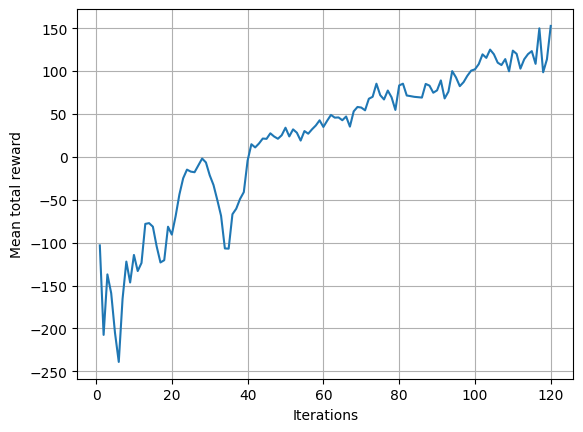

In [10]:
plt.plot(list(range(1, len(mean_total_rewards) + 1)), mean_total_rewards)
plt.xlabel("Iterations")
plt.ylabel("Mean total reward")
plt.grid()

In [14]:
agent.save_model("lunar_lander_model.pth")

# Mountain Car

In [ ]:
network = AgentNetwork(
    [2, 64, 1],
    # min_state=torch.tensor([-1.2, -0.07]),
    # max_state=torch.tensor([0.6, 0.07])
).to(DEVICE)
network

In [ ]:
network.mean_state, network.std_state

In [ ]:
agent = ContinuousCrossEntropyAgent(
    network,
    state_dim=2,
    action_dim=1,
    min_action=torch.tensor([-1.0], dtype=torch.float32),
    max_action=torch.tensor([1.0], dtype=torch.float32)
)

In [ ]:
def calc_noise_epsilon(intial_noise_epsilon, iteration):
    return intial_noise_epsilon * (0.9 * 0.99 ** (iteration - 1) + 0.1)


mean_total_rewards = train_agent(
    agent,
    "MountainCarContinuous-v0",
    nn.MSELoss(),
    n_iterations=250,
    n_trajectories=100,
    q_param=0.8,
    lr=0.01,
    max_length=1000,
    calc_noise_epsilon=calc_noise_epsilon,
    solved_problem_reward=95.0
)

In [ ]:
plt.plot(list(range(1, len(mean_total_rewards) + 1)), mean_total_rewards)
plt.xlabel("Iterations")
plt.ylabel("Mean total reward")
plt.grid()

In [ ]:
agent.save_model("mountain_car_model.pth")

# Run agent

In [ ]:
!python run_agent.py lunar_lander lunar_lander_model.pth